Function Calling

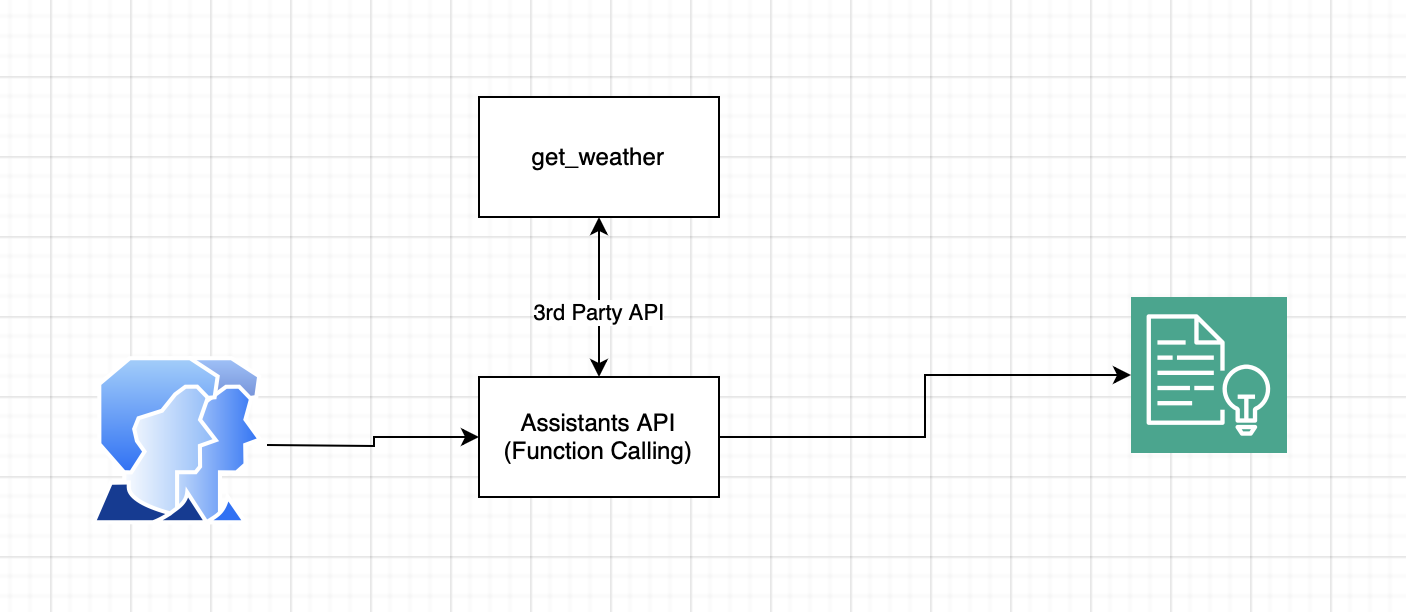

# Step 0 : Register on https://openweathermap.org/api and Get an API Key
# Step 1 : Install the OpenAI Python package with the latest version.
# Step 2 : Set up your environment variables for the Azure OpenAI endpoint and API key.
# Step 3 : Initilize the Azure OpenAI Client
# Step 4 : Define a new function get_weather
# Step 5 : Define the tools list with the functions the assistant can use
# Step 6 : Create an Assistant & Thread
# Step 7 : Loop to keep the conversation going until the user types "end"

In [3]:
# Step 1: Install the OpenAI Python package with the latest version.
%pip install openai
%pip install load_dotenv

  Obtaining dependency information for openai from https://files.pythonhosted.org/packages/cb/92/6aeef1836e66dfec7f7f160a4f06d7041be7f6ccfc47a2f0f5738b332245/openai-2.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for anyio<5,>=3.5.0 from https://files.pythonhosted.org/packages/15/b3/9b1a8074496371342ec1e796a96f99c82c945a339cd81a8e73de28b4cf9e/anyio-4.11.0-py3-none-any.whl.metadata
  Obtaining dependency information for distro<2,>=1.7.0 from https://files.pythonhosted.org/packages/12/b3/231ffd4ab1fc9d679809f356cebee130ac7daa00d6d6f3206dd4fd137e9e/distro-1.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for httpx<1,>=0.23.0 from https://files.pythonhosted.org/packages/2a/39/e50c7c3a983047577ee07d2a9e53faf5a69493943ec3f6a384bdc792deb2/httpx-0.28.1-py3-none-any.whl.metadata
  Obtaining dependency information for jiter<1,>=0.4.0 from https://files.pythonhosted.org/packages/ed/42/5823ec2b1469395a160b4bf5f14326b4a098f3b6898fbd327366789fa5d3/jiter-0.11.0-cp3

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for load_dotenv from https://files.pythonhosted.org/packages/14/2e/268a528dfa1f76999435634b0453fdd917ea878a818a6d5981632f7acffb/load_dotenv-0.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for python-dotenv from https://files.pythonhosted.org/packages/5f/ed/539768cf28c661b5b068d66d96a2f155c4971a5d55684a514c1a0e0dec2f/python_dotenv-1.1.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Step 2: Set up your environment variables for the Azure OpenAI endpoint and API key.

from openai import AzureOpenAI
from dotenv import load_dotenv
import os
load_dotenv('azureopenai.env')
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
print (azure_endpoint)
print (azure_endpoint)

https://admin-m5pajda0-eastus2.openai.azure.com
https://admin-m5pajda0-eastus2.openai.azure.com


In [7]:
# Step 3: Initialize the Azure OpenAI Client

import os
import json
import requests
import time
from openai import AzureOpenAI

# Initialize the Azure OpenAI client with environment variables for the endpoint, API key, and API version
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),  # Azure OpenAI endpoint
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),          # API key for Azure OpenAI
    api_version="2024-05-01-preview"                    # API version to use
)

In [8]:
# Step 4 : Define a new function get_weather

def get_weather(latitude, longitude):
    """Get the weather condition for a given location using latitude and longitude."""

    # Check if latitude or longitude are None or 0
    if latitude is None:
        return json.dumps({"weatherAPI_response": "Required argument latitude is not provided?"})
    if longitude is None:
        return json.dumps({"weatherAPI_response": "Required argument longitude is not provided?"})
    if latitude>90 or latitude<-90:
        return json.dumps({"weatherAPI_response": "Invalid latitude value"})
    if longitude>180 or longitude<-180:
        return json.dumps({"weatherAPI_response": "Invalid longitude value"})

 # Proceed with API call if both arguments are present
    api_key = os.getenv("OPENWEATHERMAP_API_KEY")  # API key for OpenWeatherMap
    base_url = "https://api.openweathermap.org/data/3.0/onecall?"  # Base URL for OpenWeatherMap API
    complete_url = f"{base_url}lat={latitude}&lon={longitude}&appid={api_key}&units=metric"  # Complete URL with parameters

    response = requests.get(complete_url)  # Make the request to OpenWeatherMap API
    weather_data = response.json()         # Parse the JSON response

    # Extract weather information from the response
    weather_condition = weather_data["current"]["weather"][0]["description"]
    temperature = weather_data["current"]["temp"]

    return json.dumps({
        "latitude": latitude,
        "longitude": longitude,
        "weather_condition": weather_condition,
        "temperature": temperature
    })


In [36]:
# Step 5 : Define the tools list with the functions the assistant can use
tools_list = [{
    "type": "function",
    "function": {
        "name": "get_weather",
        "description": "Get the weather condition using latitude and longitude. If any argument is missing in the user message, assume it as 'null' and not zero (0) or don't return missing argument value yourself",
        "parameters": {
            "type": "object",
            "properties": {
                "latitude": {
                    "type": "number",
                    "description": "Latitude of the location"
                },
                "longitude": {
                    "type": "number",
                    "description": "Longitude of the location"
                }
            },
            "required": ["latitude", "longitude"]
        }
    }
}]


In [37]:
# Step 6 : Create an Assistant & Thread
assistant = client.beta.assistants.create(
    name="Weather Assistant",  # Name of the assistant
    instructions="You are a weather assistant that provides weather information using real-time data",  # Instructions for the assistant
    tools=tools_list,  # List of tools the assistant can use
    model="gpt-aoai-text",  # Deployment name in Azure OpenAI to use for the assistant
)

thread = client.beta.threads.create()  # Create a new conversation thread


In [38]:
# Step 6 : Create a function for running the conversation

def run_conversation(user_message):

    """Run the conversation with the assistant using user input."""
    # Create a user message in the thread
    message = client.beta.threads.messages.create(
        thread_id=thread.id,         # ID of the thread
        role="user",                 # Role of the message sender
        content=user_message         # User message content
    )

    # Create a run for the thread
    run = client.beta.threads.runs.create(
        thread_id=thread.id,          # ID of the thread
        assistant_id=assistant.id    # ID of the assistant
    )

    while True:
        time.sleep(5)  # Wait for 5 seconds before checking the status

        # Retrieve the status of the run
        run_status = client.beta.threads.runs.retrieve(
            thread_id=thread.id,    # ID of the thread
            run_id=run.id           # ID of the run
        )

        # Default message in case the AI doesn't call any function
        assistant_message_content = "No function calls were made by the model."

        if run_status.status == 'completed':
            # Get the last response from the assistant
            messages = client.beta.threads.messages.list(
                thread_id=thread.id  # ID of the thread
            ).data

            # Print only the assistant's last response
            last_response = next((msg for msg in messages if msg.role == 'assistant'), None)
            if last_response:
                assistant_message_content = (last_response.content[0].text.value)
                print(assistant_message_content)  # Print the assistant's last response
            break

        elif run_status.status == 'requires_action':
            # Handle cases where the assistant requires additional information or actions
            required_actions = run_status.required_action.submit_tool_outputs.model_dump()
            tool_outputs = []
            for action in required_actions["tool_calls"]:
                func_name = action['function']['name']
                arguments = json.loads(action['function']['arguments'])

                if func_name == "get_weather":
                    output = get_weather(
                        latitude=arguments.get('latitude'),
                        longitude=arguments.get('longitude')
                    )
                    tool_outputs.append({
                        "tool_call_id": action['id'],
                        "output": output
                    })
                else:
                    raise ValueError(f"Unknown function: {func_name}")

            # Submit tool outputs to the assistant
            client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id,
                run_id=run.id,
                tool_outputs=tool_outputs
            )
        else:
            print("Waiting for the Assistant to process...")
            time.sleep(5)  # Wait for 5 seconds before checking the status again



In [39]:
# Step 7 : Loop to keep the conversation going until the user types "end"
while True:
    user_message = input("\nEnter your message (type 'end' to stop): ")  # Get user input
    if user_message.lower() == "end":
        print("\nConversation ended.")  # Print message when conversation ends
        break
    run_conversation(user_message)  # Run the conversation with the user's message



Enter your message (type 'end' to stop): Please give me the current weather in London
The current weather in London is clear sky with a temperature of 20.95°C.

Enter your message (type 'end' to stop): Please give weather in New Delhi
The current weather in New Delhi is mist with a temperature of 27.07°C.


KeyboardInterrupt: Interrupted by user


Enter your message (type 'end' to stop): get the latitude and longitude of New Delhi


NameError: name 'thread' is not defined